# Lab 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle


###  Load the Labeled Faces in the Wild (LFW) dataset from Sciki

In [3]:
faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])

## Class Balance

### Check Class Balance

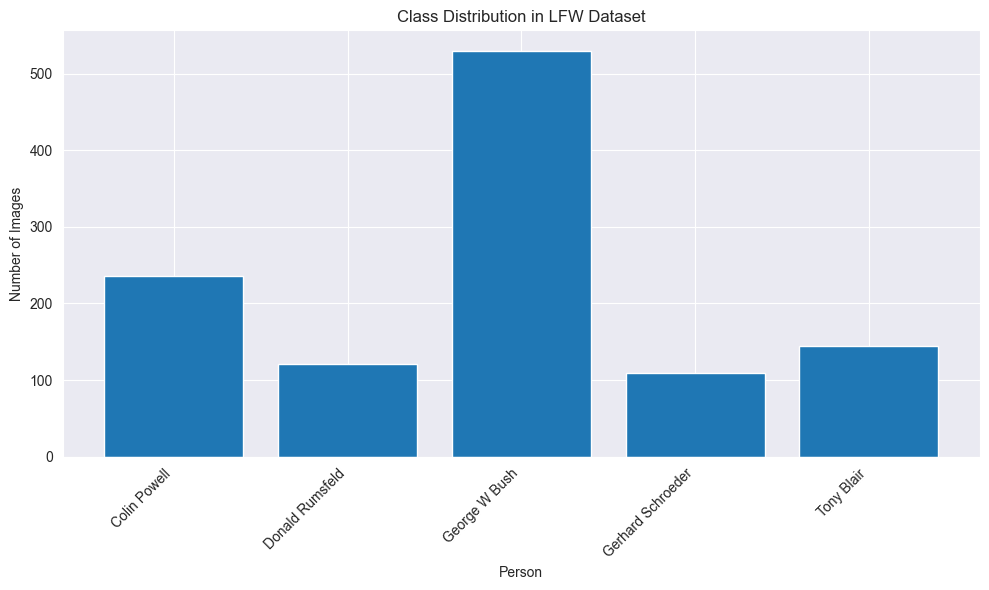

In [4]:
unique, counts = np.unique(faces.target, axis=0, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(range(len(unique)), counts)
plt.xticks(range(len(unique)), faces.target_names[unique], rotation=45, ha='right')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('Class Distribution in LFW Dataset')
plt.tight_layout()
plt.show()

### Balancing Strategy Implementation and Justification

Original samples of each class: [236 121 530 109 144]
Balanced samples of each class: [109 109 109 109 109]
Total samples: 1140 -> 545


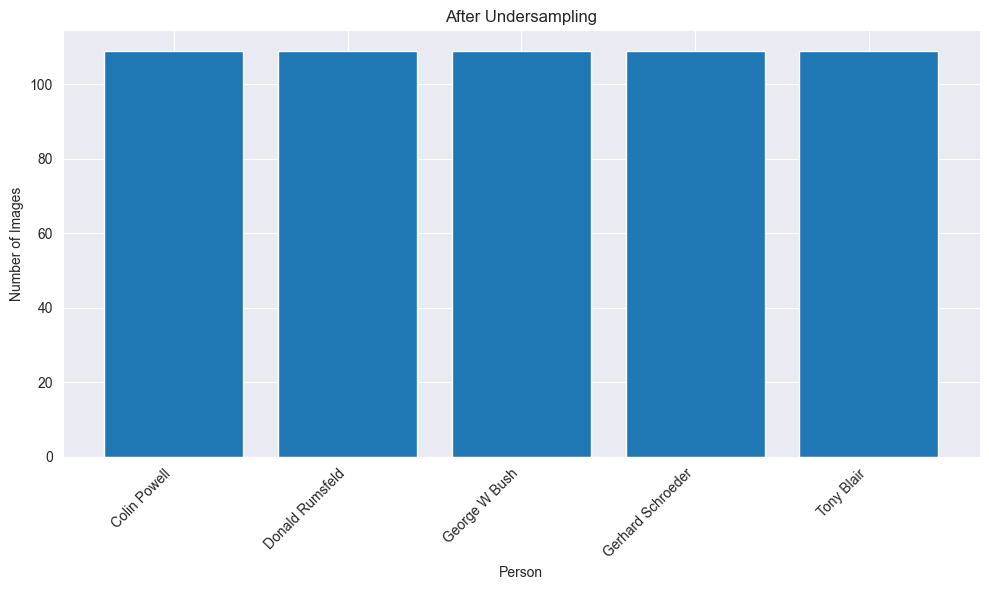

In [5]:
sam_min = np.min(counts)
balanced_peo = []
for i in unique:
    class_indices = np.where(faces.target == i)[0]
    selected = np.random.choice(class_indices, sam_min, replace=False)
    balanced_peo.extend(selected)

balanced_peo = np.array(balanced_peo)
np.random.shuffle(balanced_peo)

X_b = faces.data[balanced_peo]
y_b = faces.target[balanced_peo]

unique_new, counts_new = np.unique(y_b, return_counts=True)
print(f"Original samples of each class: {counts}")
print(f"Balanced samples of each class: {counts_new}")
print(f"Total samples: {len(faces.data)} -> {len(X_b)}")


plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_new)), counts_new)
plt.xticks(range(len(unique_new)), faces.target_names[unique_new], rotation=45, ha='right')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.title('After Undersampling')
plt.tight_layout()
plt.show()

### Intra-/Inter-Class Variance Comparison

In [34]:

def compute_class_variance(X, y):
    intra = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_mean = np.mean(class_data, axis=0)
        variance = np.mean(np.sum((class_data - class_mean) ** 2, axis=1))
        intra.append(variance)

    class_means = []
    for label in np.unique(y):
        class_data = X[y == label]
        class_means.append(np.mean(class_data, axis=0))
    class_means = np.array(class_means)
    overall_mean = np.mean(X, axis=0)
    inter = np.mean(np.sum((class_means - overall_mean) ** 2, axis=1))

    return np.mean(intra), inter

intra_before, inter_before = compute_class_variance(faces.data, faces.target)
intra_after, inter_after = compute_class_variance(X_b, y_b)

print(f"Before balancing: Intra-class variance: {intra_before:.2f}, Inter-class variance: {inter_before:.2f}")
print(f"After balancing: Intra-class variance: {intra_after:.2f}, Inter-class variance: {inter_after:.2f}")



Before balancing: Intra-class variance: 61.51, Inter-class variance: 2.80
After balancing: Intra-class variance: 60.08, Inter-class variance: 2.49


## Linear SVM Baseline

### Grid Search and Reporting

C=0.001: Accuracy=0.2683, Time=0.19s
C=0.01: Accuracy=0.7622, Time=0.15s
C=0.03: Accuracy=0.8720, Time=0.14s
C=0.05: Accuracy=0.8902, Time=0.13s
C=1: Accuracy=0.8780, Time=0.14s
C=10: Accuracy=0.8780, Time=0.13s
C=100: Accuracy=0.8780, Time=0.13s

Best C: 0.05 with accuracy: 0.8902

Best Linear SVM Results (C=0.05):
Accuracy: 0.8902
Training Time: 0.12s


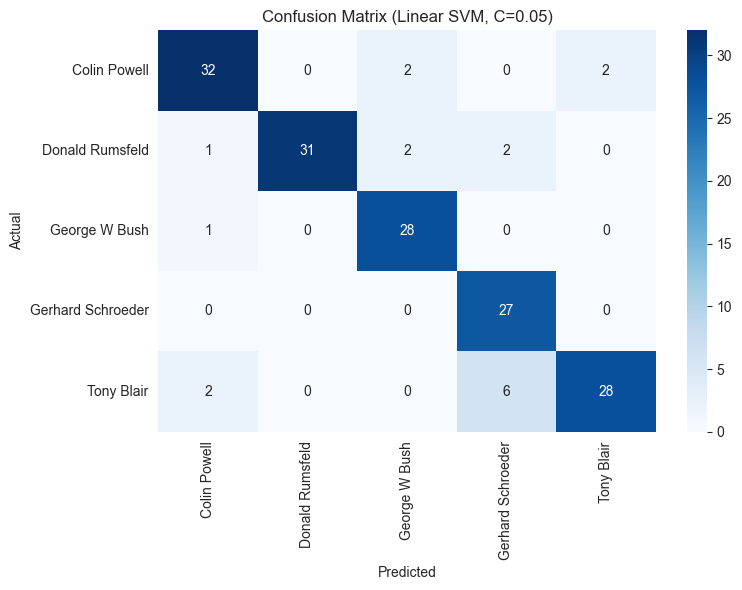

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.3, random_state=42)

C_values = [0.001, 0.01, 0.03,0.05,1, 10, 100]
results = []

for C in C_values:
    start_time = time.time()
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((C, acc, train_time))
    print(f"C={C}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

best_result = max(results, key=lambda x: x[1])
best_C = best_result[0]
print(f"\nBest C: {best_C} with accuracy: {best_result[1]:.4f}")



start_time = time.time()
best_svm = SVC(kernel='linear', C=best_C)
best_svm.fit(X_train, y_train)
best_train_time = time.time() - start_time

y_pred_best = best_svm.predict(X_test)
best_acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)

print(f"\nBest Linear SVM Results (C={best_C}):")
print(f"Accuracy: {best_acc:.4f}")
print(f"Training Time: {best_train_time:.2f}s")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names[unique_new],
            yticklabels=faces.target_names[unique_new])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Linear SVM, C={best_C})')
plt.tight_layout()
plt.show()

### Explanation of $C$

- Small C: Corresponds to a soft margin. It has wider margin, and allows some misclassifications in the training set to maximize the margin width. Given the high intra-class variance noted in Section 2, a soft margin is crucial here. It prevents the model from overfitting.
- Large C: Corresponds to a hard margin. It has smaller margin and ewer violations. In our results, increasing $C$ to 10 did not improve accuracy but have a slightly decrease. This confirms that forcing the model to perfectly separate the noisy training data does not help generalization on the test set for this specific dataset.

## Kernel Experiments

### Evaluate Various Kernels

In [35]:
kernels = ['poly', 'rbf', 'sigmoid']


for kernel in kernels:
    start_time = time.time()
    svm = SVC(kernel=kernel, gamma='scale')
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Kernel={kernel}: Accuracy={acc:.4f}, Time={train_time:.2f}s")

Kernel=poly: Accuracy=0.8720, Time=0.07s
Kernel=rbf: Accuracy=0.7378, Time=0.08s
Kernel=sigmoid: Accuracy=0.1646, Time=0.09s


### Learning Curves and Hyperparameter Sensitivity (Poly Kernel)

ACC: 0.5122
ACC: 0.6341
ACC: 0.6890
ACC: 0.7866
ACC: 0.7927
ACC: 0.7866
ACC: 0.8232
ACC: 0.8415
ACC: 0.8476
ACC: 0.8720


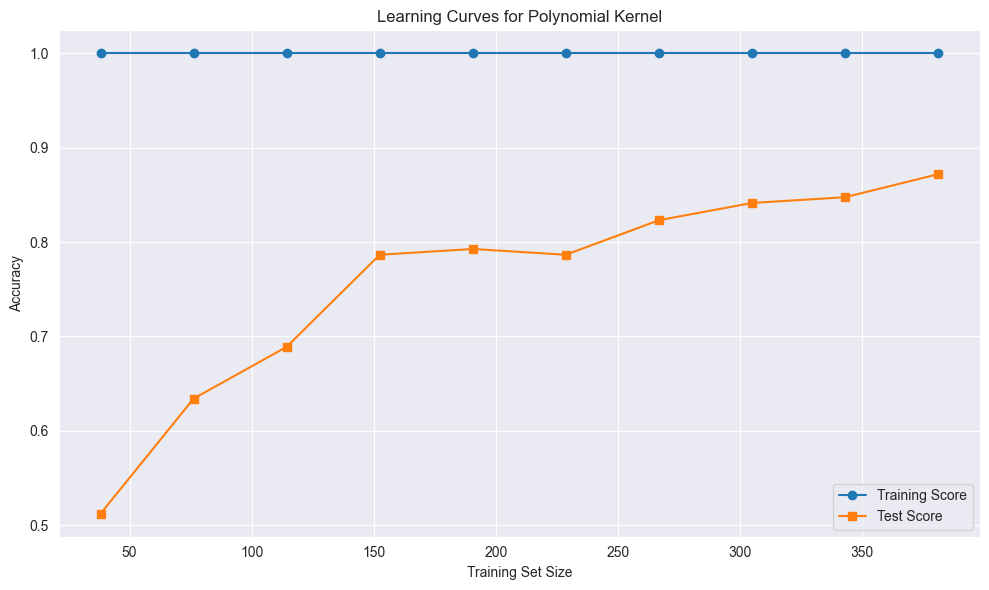

Gamma=0.0001: Test Accuracy=0.1646
Gamma=0.001: Test Accuracy=0.4024
Gamma=0.01: Test Accuracy=0.8720
Gamma=0.1: Test Accuracy=0.8720
Gamma=1: Test Accuracy=0.8720


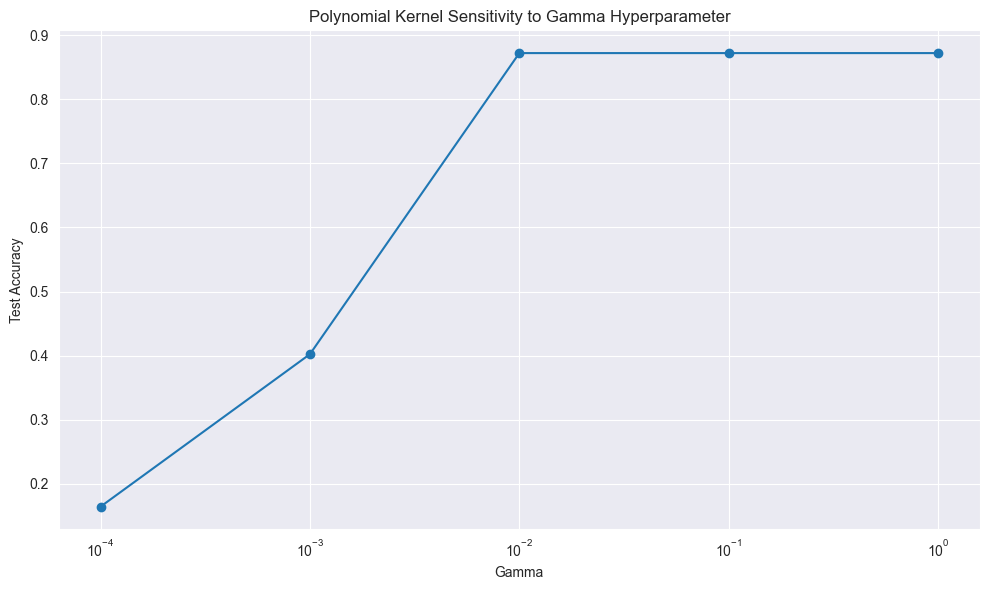

C=0.001: Test Accuracy=0.4939
C=0.01: Test Accuracy=0.8171
C=0.05: Test Accuracy=0.8598
C=0.1: Test Accuracy=0.8720
C=1: Test Accuracy=0.8720


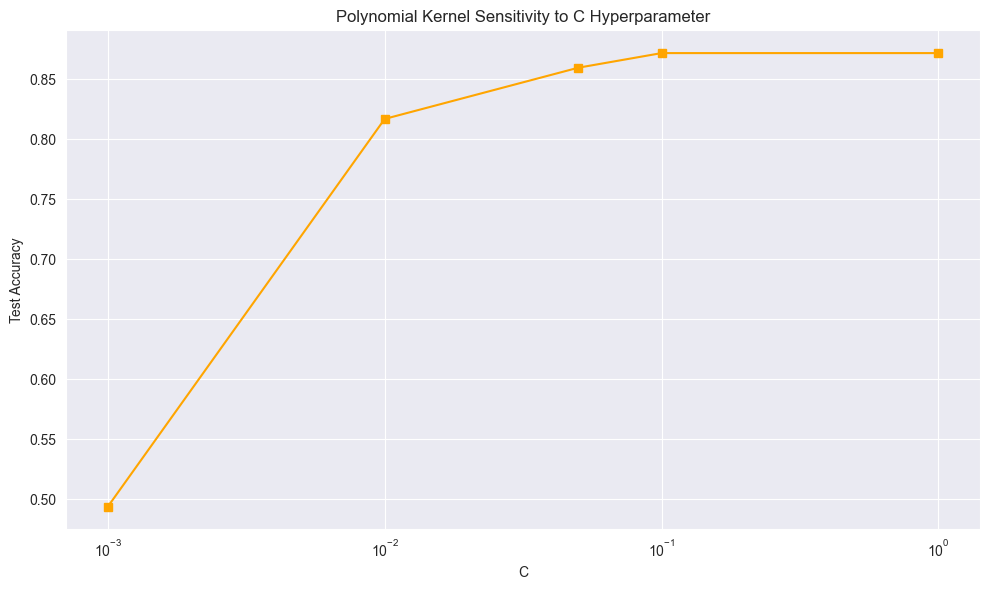

In [38]:

train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]

    svm_poly = SVC(kernel='poly', gamma='scale')
    svm_poly.fit(X_subset, y_subset)

    train_score = svm_poly.score(X_subset, y_subset)
    test_score = svm_poly.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

    print(f"ACC: {test_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Score', marker='o')
plt.plot(train_sizes * len(X_train), test_scores, label='Test Score', marker='s')
plt.xlabel('Size')
plt.ylabel('Acc')
plt.title('Learning Curves: Polynomial Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

gamma_values = [0.0001, 0.001, 0.01, 0.1, 1]
gamma_results = []

for gamma in gamma_values:
    svm_poly = SVC(kernel='poly', gamma=gamma)
    svm_poly.fit(X_train, y_train)
    test_acc = svm_poly.score(X_test, y_test)
    gamma_results.append(test_acc)
    print(f"Gamma={gamma}: Test Accuracy={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(gamma_values, gamma_results, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Test Accuracy')
plt.title('Polynomial Kernel Sensitive to Gamma')
plt.grid(True)
plt.tight_layout()
plt.show()

C_values_poly = [0.001, 0.01, 0.05, 0.1, 1, 10]
C_results = []

for C in C_values_poly:
    svm_poly = SVC(kernel='poly', gamma='scale', C=C)
    svm_poly.fit(X_train, y_train)
    test_acc = svm_poly.score(X_test, y_test)
    C_results.append(test_acc)
    print(f"C={C}: Test Accuracy={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(C_values_poly, C_results, marker='s', color='orange')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Polynomial Kernel Sensitive to C')
plt.grid(True)
plt.tight_layout()
plt.show()